# Cox regression and hazard ratio model

Cox performs an analysis of each given variable and predicts, for each one, the hazard ratio, that is, a probability. If the hazard ratio is >1, it indicates that the risk of the event occurring increases as the value of that variable increases (or with the presence of that variable in the case of boolean variables), whereas it decreases if the hazard ratio is <1.


Input: feature vectors including patient age at diagnosis, last days to follow-up, death event (boolean), and a miRNA-seq vector with values normalized using log and quantile normalization.

Pipeline:
    - Scaling with Z-scaler** on age fields and miRNA-seq data  
    - Application of Elastic Net via `scikit-survival.CoxnetSurvivalAnalysis` to be trained  
      - Documentation: https://scikit-survival.readthedocs.io/en/stable/user_guide/coxnet.html  
    - Application of grid search and K-fold cross-validation to determine the best set of parameters  
    - Computation of the risk score using the `predict` function  
    - It is also possible to predict the survival function or the cumulative hazard function, but fine-tuning is required using the parameter `fit_baseline_model=True`


Motivations:
    - Z-scaler is used to bring predictive values onto the same scale with variance 1 and mean 0
    - Use of penalized Cox regression to perform feature selection and select only the most relevant miRNAs
    - Use of Elastic Net because standard Lasso-Cox is not optimal for two reasons: it cannot select more features than the number of samples, and in groups of highly correlated features it randomly selects only one among them. Elastic Net addresses these issues by combining L1 and L2 penalties, making the model more robust.

## Init

In [7]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import json 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sksurv.metrics import integrated_brier_score, brier_score
from sksurv.linear_model import CoxnetSurvivalAnalysis
import warnings
from sklearn.exceptions import FitFailedWarning
from sksurv.metrics import concordance_index_censored
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.decomposition import KernelPCA

warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", ConvergenceWarning)
warnings.simplefilter("ignore", FitFailedWarning)

In [8]:
ROOT = "\\".join(os.getcwd().split("\\")[:-1])
# print(ROOT)
DATA_PATH = os.path.join(ROOT, 'datasets\\preprocessed')
SEED = 42
NUM_FOLDS = 10
USE_CLINICAL = True

In [9]:
datasets = [
    'miRNA\\clinical_miRNA_normalized_log.csv', 
    'miRNA\\clinical_miRNA_normalized_quant.csv',
    'mRNA\\clinical_mRNA_normalized_log.csv', 
    'mRNA\\clinical_mRNA_normalized_tpm_log.csv'
]
dataset_name = datasets[0]
DATASET_TYPE = dataset_name.split('\\')[-1][9:-4]
DATASET_TYPE = 'clinical_'+DATASET_TYPE if USE_CLINICAL else 'seq_only'+DATASET_TYPE
SUBTYPE=dataset_name.split("\\")[0]

In [19]:
def parse_array(x):
    if isinstance(x, str):
        x = x.strip('[]')
        return eval(x, {'np':np})

## Prepare data

In [13]:
def prepare_data(dataset, use_clinical):
    y_cols = ['Death', 'days_to_death', 'days_to_last_followup']
    if use_clinical:
        print('USING clinical data') 
        X_cols = [col for col in dataset.columns if col not in y_cols]
    else:
        print('EXCLUDING clinical data') 
        miRNA_clinical_cols = [col for col in dataset.columns if col not in y_cols and 'hsa' not in col]
        mRNA_clinical_cols = [col for col in dataset.columns if col not in y_cols and 'gene.' not in col]
        X_cols = [col for col in dataset.columns if col not in y_cols and not col in miRNA_clinical_cols and col not in mRNA_clinical_cols]

    custom_dtype = np.dtype([
        ('event', np.bool_),      # O 'bool'
        ('time', np.float64)      # O 'float'
    ])

    y = []
    for index,row in dataset[y_cols].iterrows():
        if row['Death'] == 1:
            y.append(np.array((True, row['days_to_death'].item()), dtype=custom_dtype))
        elif row['Death'] == 0:
            tuple = (False, row['days_to_last_followup'].item())
            y.append(np.array(tuple, dtype=custom_dtype)) 
    y = np.array(y)

    X = dataset[X_cols]
    return X, y

def scale_data(X):
    scaler = StandardScaler()

    genes_cols = [col for col in X.columns if 'hsa' in col or 'gene.' in col]
    genes_cols.append('age_at_initial_pathologic_diagnosis')
    scaled_X = pd.DataFrame(scaler.fit_transform(X[genes_cols]), columns=genes_cols)

    X[genes_cols] = scaled_X
    return X

In [15]:
dataset = pd.read_csv(os.path.join(DATA_PATH, dataset_name))
X, y = prepare_data(dataset, USE_CLINICAL)
X = scale_data(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
kfold = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)

USING clinical data


C:\Users\Matteo Bulgarelli\AppData\Local\Temp\ipykernel_15696\1619319578.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[genes_cols] = scaled_X


## Getting best parameters

In [21]:
def c_index_scorer(estimator, X, y):
    # Estrai i campi 'death' e 'days' da y
    event_indicator = y['event']
    event_time = y['time']
    # Predici i punteggi di rischio
    risk_scores = estimator.predict(X)
    # Calcola il concordance index
    c_index = concordance_index_censored(event_indicator, event_time, risk_scores)[0]
    return c_index

In [16]:
def gcv(cen, kfold, X_train, y_train):
    gcv = GridSearchCV(
        cen,
        param_grid={
            "l1_ratio": [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            "alpha_min_ratio":[0.01, 0.05, 0.1]
        },
        cv=kfold,
        error_score=0.5,
        n_jobs=8,
    ).fit(X_train, y_train)
    return gcv.best_params_['alpha_min_ratio'], gcv.best_params_['l1_ratio']

def rcv(kfold, X_train, y_train, alpha_min_ratio, l1_ratio, subtype, dataset_type, save_res=False):
    cen = CoxnetSurvivalAnalysis(l1_ratio=l1_ratio, alpha_min_ratio=alpha_min_ratio)

    cen.fit(X_train, y_train)
    estimated_alphas = cen.alphas_
    rcv = RandomizedSearchCV(
        cen,
        param_distributions={
            "alphas":[[v] for v in map(float, estimated_alphas)]
        },
        cv=kfold,
        scoring=c_index_scorer,
        error_score=0.5,
        n_iter=30, # 30
        n_jobs=8,
        verbose=0,
        random_state=SEED
    ).fit(X_train, y_train)
    
    res = pd.DataFrame(rcv.cv_results_)
    if save_res:
        res.to_csv(os.path.join(ROOT, f"grid_searches/{subtype}/{dataset_type}_alphas.csv"), index=False)

    cols = X_train.columns[(rcv.best_estimator_.coef_ != 0)[:, 0]]
    return rcv.best_params_['alphas'], cols.values.tolist(), res

def filter_alphas(res, best_params, X_train, y_train):
    #filtering best alpha
    elegible_models = []
    min_cols_model = None
    for i in range(len(res['param_alphas'])):
        print(f'Testing alpha {i}/{len(res['param_alphas'])}')
        cen = CoxnetSurvivalAnalysis(l1_ratio = best_params['prePCA']['l1_ratio'], alpha_min_ratio = best_params['prePCA']['alpha_min_ratio'], alphas=[res['param_alphas'][i]], max_iter=100000)
        
        try:
            cen.fit(X_train, y_train)
        except Exception as e:
            if isinstance(e, ArithmeticError):
                print("ArithmeticError occurred")
                continue
            else:
                print(e)
                continue

        non0_coefs = cen.coef_[cen.coef_ != 0]
        cols = X_train.columns[(cen.coef_ != 0)[:, 0]]
        if min_cols_model is None or (len(non0_coefs) > 20 and len(non0_coefs) < min_cols_model['num_coefs']):
            min_cols_model={
                'model':cen,
                'num_coefs':len(non0_coefs),
                'filtered_best_alpha':res['param_alphas'][i],
                'score':res['mean_test_score'][i]
            }

        if len(non0_coefs) > 100 and len(non0_coefs) <=200:
            elegible_models.append({
                'model':cen,
                'num_coefs':len(non0_coefs),
                'filtered_best_alpha':res['param_alphas'][i],
                'score':res['mean_test_score'][i]
            })
        
    if len(elegible_models) != 0:
        best_model = elegible_models[0]
        for model in elegible_models:
            if model != best_model and model['score'] > best_model['score']:
                best_model = model
    else:
        best_model = min_cols_model

    return best_model['filtered_best_alpha'], cols.values.tolist()

In [17]:
def search_best_params_prePCA(kfold, X_train, y_train, subtype, dataset_type, status_pca='prePCA'):
    dir = os.path.join(ROOT, f"grid_searches/cox_regression/{subtype}/{dataset_type}")
    os.makedirs(dir, exist_ok=True)

    bp_path = os.path.join(dir,f"best_params.json")
    alphas_path = os.path.join(dir, f"alphas_{status_pca}.csv")

    cen = CoxnetSurvivalAnalysis()
    best_params = {}

    # search if already computed
    if os.path.exists(bp_path) and os.path.exists(alphas_path):
        print(f'Found best parameters')
        with open(bp_path, 'r') as f:
            best_params = json.load(f)
            res = pd.read_csv(alphas_path)
            res['param_alphas'] = res['param_alphas'].apply(parse_array)
            print(best_params)
        
    # Compute best parameters with grid search and random search    
    else:
        print(f"Computing new params {status_pca} from scratch")

        X_train_gen = X_train[[col for col in X_train.columns if col.startswith('hsa') or col.startswith('gene.')]]
        best_params[status_pca] = {}
        best_params[status_pca]['alpha_min_ratio'], best_params[status_pca]['l1_ratio'] = gcv(cen, kfold, X_train_gen, y_train)
        print(f"Computed best alpha_min_ratio {best_params[status_pca]['alpha_min_ratio']} and l1_ratio {best_params[status_pca]['l1_ratio']}")
        
        best_params[status_pca]['rcv'] = {}
        best_params[status_pca]['filtered'] = {}
        
        print("Computing best alphas")
        best_params[status_pca]['rcv']['best_alpha'], best_params[status_pca]['rcv']['cols'], res = rcv(kfold, X_train_gen, y_train, best_params[status_pca]['alpha_min_ratio'], best_params[status_pca]['l1_ratio'], subtype, dataset_type)
        print(f"Found possible best allpha with RCV: {best_params[status_pca]['rcv']['best_alpha']}")
        best_params[status_pca]['filtered']['best_alpha'], best_params[status_pca]['filtered']['cols'] = filter_alphas(res, best_params, X_train_gen, y_train)
        
        print(f"Found possible best alpha with our filtering: {best_params[status_pca]['filtered']['best_alpha']}")

        best_params['postPCA'] = {}

        # saving best params
        print(f"Saving best_params_{status_pca} into: {bp_path}")

        with open(bp_path, 'w') as f:
            json.dump(best_params, f)

        res.to_csv(alphas_path, index=False)
        res['param_alphas'] = res['param_alphas'].apply(lambda x: x[0])

    return best_params, res

In [20]:
print('Searching best params for genes reads'.center(100, '-'))
best_params, res = search_best_params_prePCA(kfold, X_train, y_train, SUBTYPE, DATASET_TYPE)
print("Finished computing best params, running test...".center(100, '-'))

-------------------------------Searching best params for genes reads--------------------------------
Found best parameters
{'prePCA': {'alpha_min_ratio': 0.1, 'l1_ratio': 0.5, 'rcv': {'best_alpha': [0.17921236669033763], 'cols': ['hsa-mir-7705']}, 'filtered': {'best_alpha': [0.02853567678349578], 'cols': ['hsa-mir-122', 'hsa-mir-1226', 'hsa-mir-1229', 'hsa-mir-1246', 'hsa-mir-1247', 'hsa-mir-1251', 'hsa-mir-1260b', 'hsa-mir-1275', 'hsa-mir-129-1', 'hsa-mir-1293', 'hsa-mir-1303', 'hsa-mir-1305', 'hsa-mir-133b', 'hsa-mir-135a-1', 'hsa-mir-135a-2', 'hsa-mir-187', 'hsa-mir-18a', 'hsa-mir-1913', 'hsa-mir-1915', 'hsa-mir-196a-1', 'hsa-mir-196a-2', 'hsa-mir-198', 'hsa-mir-203a', 'hsa-mir-219b', 'hsa-mir-3130-2', 'hsa-mir-3136', 'hsa-mir-3137', 'hsa-mir-3138', 'hsa-mir-3151', 'hsa-mir-3152', 'hsa-mir-3160-2', 'hsa-mir-3173', 'hsa-mir-3181', 'hsa-mir-3182', 'hsa-mir-3186', 'hsa-mir-3190', 'hsa-mir-320d-1', 'hsa-mir-329-2', 'hsa-mir-3619', 'hsa-mir-3655', 'hsa-mir-3661', 'hsa-mir-3662', 'hsa-mir

## Run tests

### Scoring functions

In [22]:
def integrated_brier_scorer(estimator, X, y):
    """
    Computes the Integrated Brier Score (IBS) for a survival estimator.
    
    Note: Returns the negative IBS because cross_val_score maximizes the score.
    """
    
    # 1. Define the time points for which to compute the score.
    # A common choice is the unique event times in the test set.
    # We must ensure there is more than one unique time point.
    unique_times = np.unique(y['time'][y['event'] == 1])
    if len(unique_times) < 2:
        return 0.0 # Return 0.0 or a default safe score if insufficient data

    # Use a range of times up to the 90th percentile of event times
    max_time = np.percentile(unique_times, 90)
    times = np.linspace(unique_times.min(), max_time, 100)
    
    # 2. Get the survival function predictions for the test set
    # This calls the estimator's .predict_survival_function() method
    surv_func = estimator.predict_survival_function(X)
    
    # Extract the survival probability estimates at the specified times
    survival_probabilities = np.array([f(times) for f in surv_func])
    
    # 3. Compute the Integrated Brier Score
    ibs = integrated_brier_score(y, y, survival_probabilities, times)
    
    # Return the NEGATIVE IBS for maximization
    return ibs

def brier_scorer(kfold, estimator, X, y):
    brier_scores = []
    
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        estimator.fit(X_train, y_train)
        
        unique_times = np.unique(y_test['time'])#[y_test['event'] == 1])
        if len(unique_times) < 2:
            return 0.0 # Return 0.0 or a default safe score if insufficient data
        # Use a range of times up to the 90th percentile of event times
        max_time = np.percentile(unique_times, 90)
        times = np.linspace(unique_times.min(), max_time, 100)

        # 2. Get the survival function predictions for the test set
        # This calls the estimator's .predict_survival_function() method
        surv_func = estimator.predict_survival_function(X_test)
        
        # Extract the survival probability estimates at the specified times
        survival_probabilities = np.array([f(times) for f in surv_func])
        
        # 3. Compute the Integrated Brier Score
        ts, bs = brier_score(y_train, y_test, survival_probabilities, times)
        brier_scores.append((ts, bs))
        
    return brier_scores

### Search postPCA params

In [23]:
def search_best_params_postPCA(kfold, X_train, y_train, subtype, dataset_type, source = None, status_pca='postPCA'):
    dir = os.path.join(ROOT, f"grid_searches/cox_regression/{subtype}/{dataset_type}")
    os.makedirs(dir, exist_ok=True)

    if source is None:
        raise Exception("Source is required")

    bp_path = os.path.join(dir,f"best_params.json")
    alphas_path = os.path.join(dir, f"alphas_{status_pca}_{source}.csv")

    cen = CoxnetSurvivalAnalysis()
    best_params = {}
    with open(bp_path, 'r') as f:
        best_params['postPCA'] = json.load(f)['postPCA']

    # search if already computed
    if os.path.exists(bp_path) and os.path.exists(alphas_path):
        print(f'Found best parameters')
        with open(bp_path, 'r') as f:
            best_params = json.load(f)
            res = pd.read_csv(alphas_path)
            res['param_alphas'] = res['param_alphas'].apply(parse_array)
            print(best_params)
        return best_params, res
        
    # Compute best parameters with grid search and random search    
    else:
        print(f"Computing new params {status_pca}_{source} from scratch")
        X_train_gen = X_train

        best_params[status_pca][source] = {}
        best_params[status_pca][source]['alpha_min_ratio'], best_params[status_pca][source]['l1_ratio'] = gcv(cen, kfold, X_train_gen, y_train)        
        
        print("Computing best alphas")
        best_params[status_pca][source]['best_alpha'], best_params[status_pca][source]['cols'], res = rcv(kfold, X_train_gen, y_train, best_params[status_pca][source]['alpha_min_ratio'], best_params[status_pca][source]['l1_ratio'], subtype, dataset_type)


        # saving best params
        print(f"Saving best_params_{status_pca} into: {bp_path}")
        
        new_params = best_params.copy()
        with open(bp_path, 'r') as f:
            best_params = json.load(f)
            best_params['postPCA'] = new_params['postPCA']

        with open(bp_path, 'w') as f:
            json.dump(best_params, f)

        res.to_csv(alphas_path, index=False)
        res['param_alphas'] = res['param_alphas'].apply(lambda x: x[0])

    return best_params, res

### Plotting functions

In [24]:
def create_subplots(plot_list, caption, filename):
    # Create the figure and a 2x2 grid of Axes objects
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Flatten the 2D array of axes objects into a 1D array for easier iteration
    axs = axs.flatten()

    if len(plot_list) > len(axs):
        print(f"Warning: Only plotting the first {len(axs)} plots as the grid size is 2x2.")

    # Iterate through the functions and axes, calling the function for the corresponding subplot
    for i, (plot_func, data) in enumerate(plot_list[:len(axs)]):
        # The asterisk (*) unpacks the data tuple before passing it to the plotting function
        plot_func(axs[i], *data)
    
    # Adjust layout to prevent subplot titles and labels from overlapping
    plt.tight_layout(pad=3.0)
    plt.figtext(0.6, 0.3, f"Integrated Brier Score:{caption}")

    fig.savefig(filename)
    
def plot_alphas(ax, res, best_params, test):
    alphas = res['param_alphas']
    mean = res.mean_test_score
    std = res.std_test_score
    
    df = pd.DataFrame(data={'alphas':alphas, 'mean':mean, 'std':std})
    df = df.sort_values(by='alphas')

    alphas = df['alphas']
    mean = df['mean']
    std=df['std']

    ax.plot(alphas, mean)
    ax.set_title('Concorande-index value for each alpha tested')
    ax.set_xscale("log")
    ax.set_ylabel("concordance index")
    ax.set_xlabel("alpha")
    ax.axvline(best_params[test]['best_alpha'][0], c='C4')
    ax.axhline(0.5, color="grey", linestyle="--")
    ax.grid(True)

def boxplot_train_results(ax, data):
    ax.boxplot(data)
    ax.set_title('Boxplot of c-index values for each alpha tested')
    ax.set_ylabel('C-index')

def plot_coefs(ax, values, names):
    df = pd.DataFrame({"coefs":names, "values":values})
    df = df.sort_values(by='values', key=abs, ascending=True)

    df.plot.barh(ax=ax, legend=True)
    ax.set_title('Non 0 coefficients')
    ax.set_xlabel('coefficient value')
    ax.set_ylabel('coefficient index')
    ax.grid(True)

def plot_brier_scores(ax, scores):
    for score in scores:
        ax.plot(score[0], score[1], alpha=0.6)
    
    ax.set_title('Time-Dependent Brier Score')
    ax.set_xlabel('Time (e.g., Days, Months)')
    ax.set_ylabel('Brier Score')
    ax.grid(True, linestyle=':', alpha=0.6)

### Test pipeline

In [25]:
def run_test(best_params, res, kfold, X_train, y_train, X_test, y_test, subtype, dataset_type):
    to_test = ['rcv', 'filtered']
    dir = os.path.join(ROOT, f'results/{subtype}/{dataset_type}')
    os.makedirs(dir , exist_ok=True)
    cv_results_path = os.path.join(dir, "cv_results.txt")
    
    clin_cols = [col for col in X_train.columns if 'hsa' not in col and 'gene.' not in col]
    
    if os.path.exists(cv_results_path):
        with open(cv_results_path, 'w') as f:
            f.write('')

    for source in to_test:
        msg = ''
        alpha = best_params['prePCA'][source]['best_alpha']

        # reduce again with PCA
        num_comps = 20
        if len(best_params['prePCA'][source]['cols']) > num_comps:
            kpca = KernelPCA(n_components=num_comps, kernel='rbf')
            train_data = pd.concat([X_train[clin_cols].reset_index(drop=True), pd.DataFrame(columns=[str(i) for i in range(1, num_comps+1)], data=kpca.fit_transform(X_train[best_params['prePCA'][source]['cols']]))], axis=1)
            test_data = pd.concat([X_test[clin_cols].reset_index(drop=True), pd.DataFrame(columns=[str(i) for i in range(1, num_comps+1)], data=kpca.transform(X_test[best_params['prePCA'][source]['cols']]))], axis=1)
        else:
            train_data = X_train[clin_cols + best_params['prePCA'][source]['cols']]
            test_data = X_test[clin_cols + best_params['prePCA'][source]['cols']]

        # Find new best alpha after PCA reduction        
        best_params, res_pca = search_best_params_postPCA(kfold, train_data, y_train, subtype, dataset_type, source=source)
        alpha = best_params['postPCA'][source]['best_alpha']

        # fit and train cox for survival analysis
        print("One shot validation on test set with best parameters and reduced features")
        cen_best = CoxnetSurvivalAnalysis(alpha_min_ratio=best_params['postPCA'][source]['alpha_min_ratio'], l1_ratio=best_params['postPCA'][source]['l1_ratio'], alphas=alpha, max_iter=100000)#  #for predicting just the risk score
        cen_best.fit(train_data, y_train)
        msg += f"Finished training cen_best:\n\t{cen_best}\n"
        preds = cen_best.predict(test_data)
        msg += f"Predictions: {preds}\n"
        msg += f"Concordance index: {cen_best.score(test_data, y_test)}\n"

        msg+="Beginning cross validation\n"
        X = np.concatenate((train_data, test_data), axis=0)
        y = np.concatenate((y_train, y_test), axis=0)
        cv = cross_val_score(
            CoxnetSurvivalAnalysis(alpha_min_ratio=best_params['postPCA'][source]['alpha_min_ratio'], l1_ratio=best_params['postPCA'][source]['l1_ratio'], alphas=alpha, max_iter=100000), 
            X, y, cv=kfold, scoring=c_index_scorer)
        msg += f"Cross validation scores for C-index: {cv}\n"
        msg += f"Cross validation description:\n\tmean={cv.mean()} \n\tstd={cv.std()} \n\tmin={cv.min()} \n\tmax={cv.max()}\n\n"

        # Compute Brier Score and Integrated Brier Score
        cen_func_best = CoxnetSurvivalAnalysis(alpha_min_ratio=best_params['postPCA'][source]['alpha_min_ratio'], l1_ratio=best_params['postPCA'][source]['l1_ratio'], alphas=alpha, max_iter=100000, fit_baseline_model=True)
        brier_scores = brier_scorer(kfold, cen_func_best, X, y)     
        cv = cross_val_score(
            cen_func_best,
            X, y, cv=kfold, scoring=integrated_brier_scorer
        )
        msg += f"Cross validation scores for Integrated Brier Score (IBS): {cv}\n"
        caption = f'\n\tmean={cv.mean()} \n\tstd={cv.std()} \n\tmin={cv.min()} \n\tmax={cv.max()}\n\n'
        msg += f"Cross validation description:{caption}"

        print(msg)

        with open(cv_results_path, 'a') as f:
            f.write(msg)

        print(f"Best coefficients considered: {cen_best.coef_[cen_best.coef_ != 0]}\n {train_data.columns[np.where(cen_best.coef_ != 0)[0]]}")

        plots_to_generate = [
            (boxplot_train_results, ([res_pca['mean_test_score']])),
            (plot_alphas, (res, best_params['prePCA'], source)),
            (plot_coefs, (cen_best.coef_[cen_best.coef_ != 0], train_data.columns[np.where(cen_best.coef_ != 0)[0]])),
            (plot_brier_scores, ([brier_scores]))
        ]
        create_subplots(plots_to_generate, caption, os.path.join(dir, f'{source}_test_plots.png'))

### Test

Found best parameters
{'prePCA': {'alpha_min_ratio': 0.1, 'l1_ratio': 0.5, 'rcv': {'best_alpha': [0.17921236669033763], 'cols': ['hsa-mir-7705']}, 'filtered': {'best_alpha': [0.02853567678349578], 'cols': ['hsa-mir-122', 'hsa-mir-1226', 'hsa-mir-1229', 'hsa-mir-1246', 'hsa-mir-1247', 'hsa-mir-1251', 'hsa-mir-1260b', 'hsa-mir-1275', 'hsa-mir-129-1', 'hsa-mir-1293', 'hsa-mir-1303', 'hsa-mir-1305', 'hsa-mir-133b', 'hsa-mir-135a-1', 'hsa-mir-135a-2', 'hsa-mir-187', 'hsa-mir-18a', 'hsa-mir-1913', 'hsa-mir-1915', 'hsa-mir-196a-1', 'hsa-mir-196a-2', 'hsa-mir-198', 'hsa-mir-203a', 'hsa-mir-219b', 'hsa-mir-3130-2', 'hsa-mir-3136', 'hsa-mir-3137', 'hsa-mir-3138', 'hsa-mir-3151', 'hsa-mir-3152', 'hsa-mir-3160-2', 'hsa-mir-3173', 'hsa-mir-3181', 'hsa-mir-3182', 'hsa-mir-3186', 'hsa-mir-3190', 'hsa-mir-320d-1', 'hsa-mir-329-2', 'hsa-mir-3619', 'hsa-mir-3655', 'hsa-mir-3661', 'hsa-mir-3662', 'hsa-mir-3664', 'hsa-mir-3688-1', 'hsa-mir-371b', 'hsa-mir-372', 'hsa-mir-378f', 'hsa-mir-3912', 'hsa-mir-391

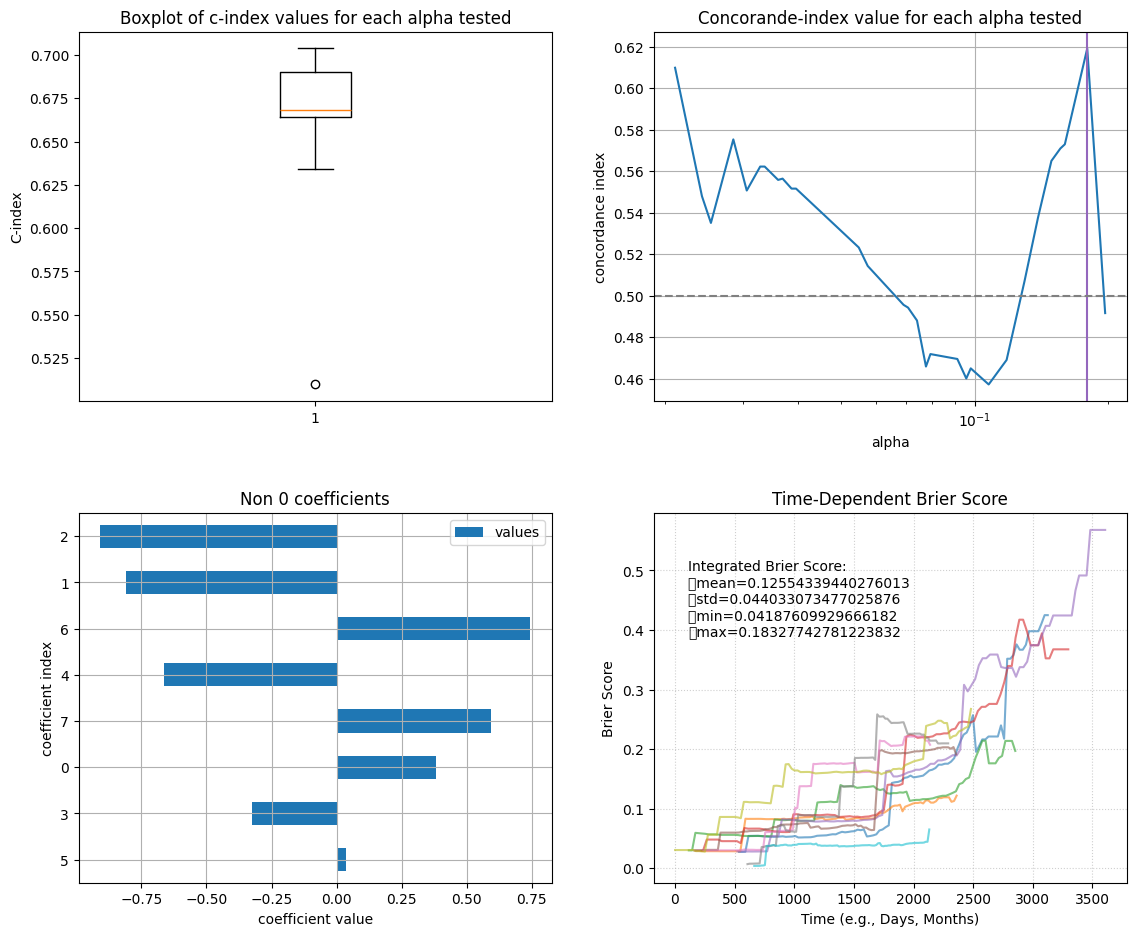

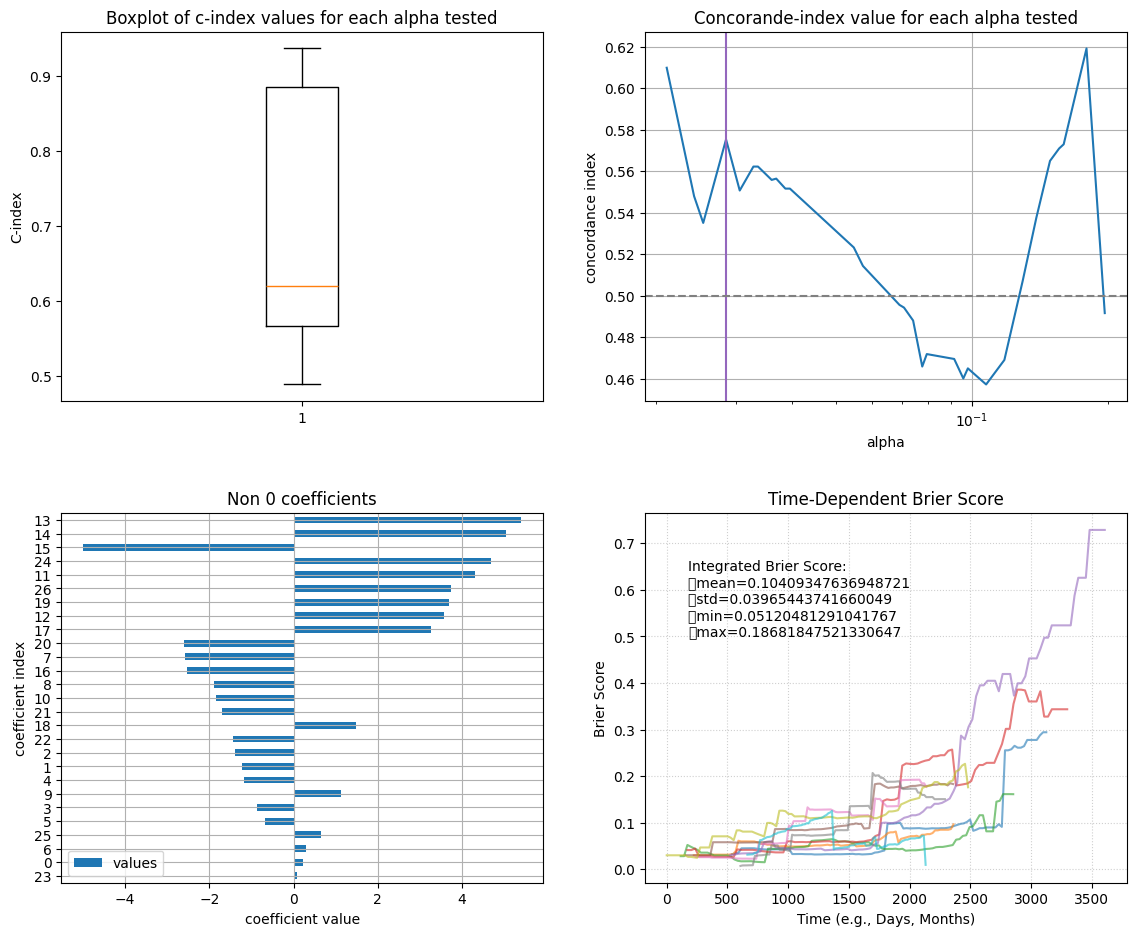

In [26]:
run_test(best_params, res, kfold, X_train, y_train, X_test, y_test, SUBTYPE, DATASET_TYPE)
print("Finished cox regression script".center(100, '-'))